In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster

In [2]:
data = pd.read_csv("../../clustering_R3.csv")

In [3]:
data

,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814
...,...,...,...
995,327.058500,95.042417,5.819534
996,379.871471,118.620443,13.329955
997,386.363714,97.265599,8.635707
998,331.269212,100.623285,6.228514


Na początku przyjrzyjmy się danym:

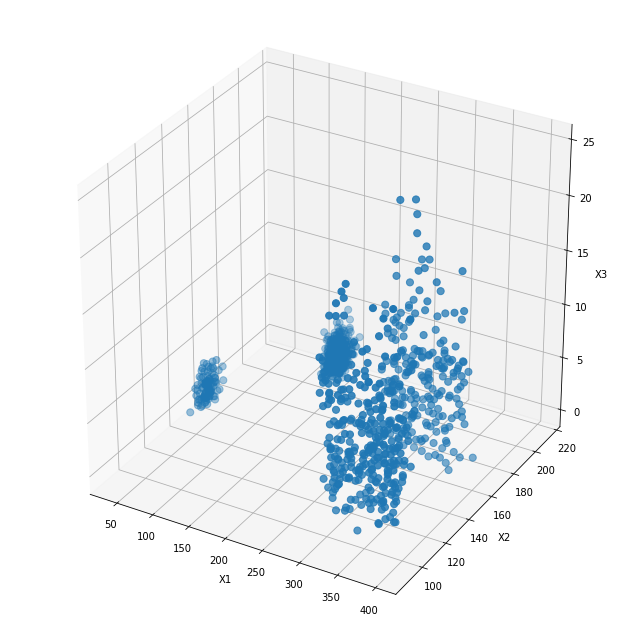

In [4]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data.X1, data.X2, data.X3, s=50)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.tight_layout()
plt.show()

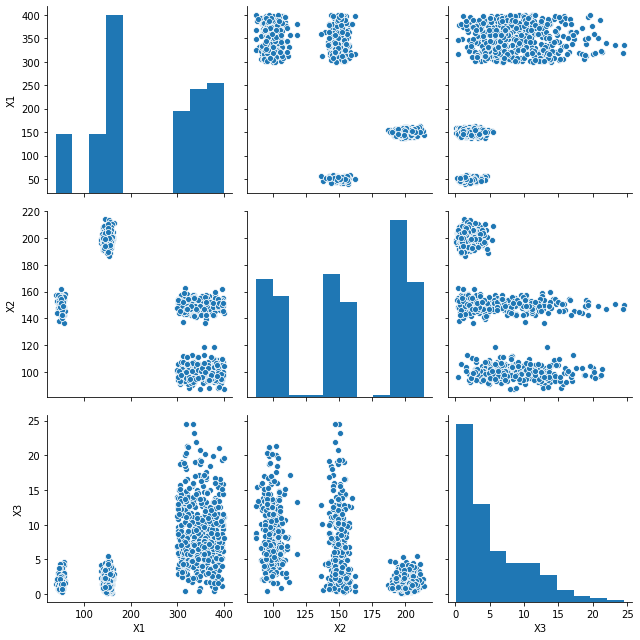

In [5]:
sns.pairplot(data, height=3)
plt.tight_layout()

Patrząc ludzkim okiem powinniśmy dostać 4 (lub ewentualnie 3) klastry. 
Do klasteryzacji użyte zostaną algorytmy k-means oraz DBSCAN.

### k-means

In [6]:
def KMeans(X,n):
    kmeans = cluster.KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    return y_pred

Dla spodziewanych 4 klastrów:

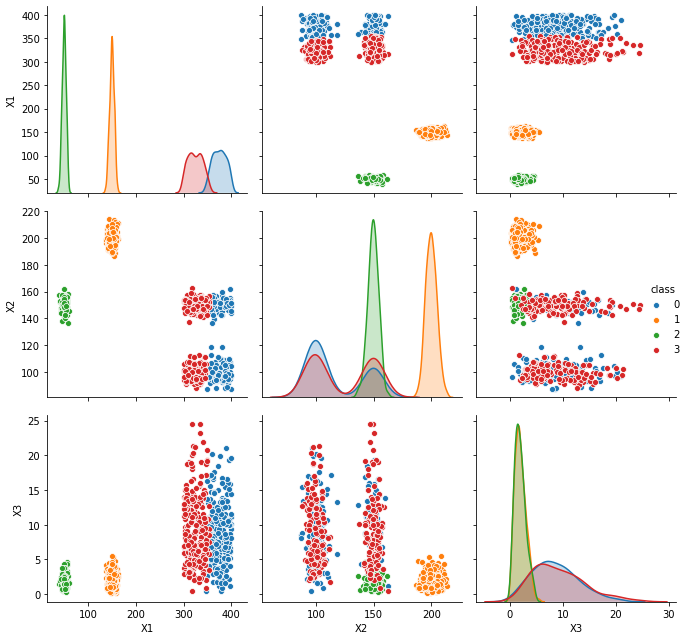

In [7]:
import copy
kmeans_data = copy.deepcopy(data)
kmeans_data['class'] = KMeans(kmeans_data,4)
sns.pairplot(kmeans_data, height=3, hue='class')
plt.tight_layout()

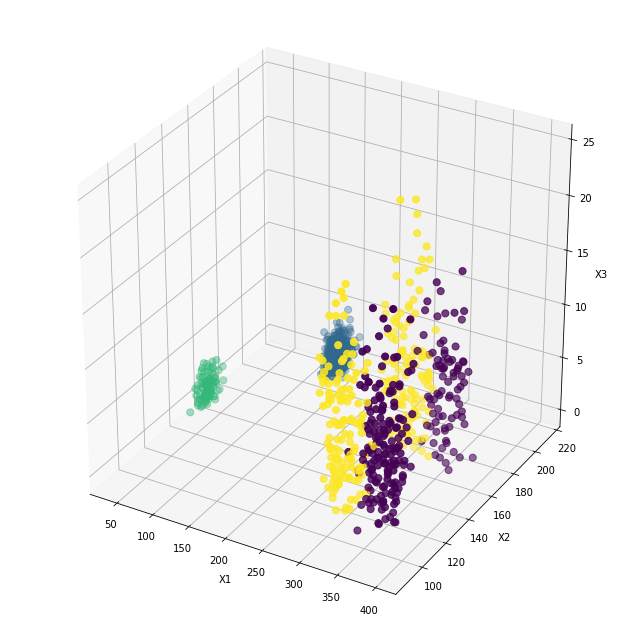

In [8]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(kmeans_data.X1, kmeans_data.X2, kmeans_data.X3, s=50, c = kmeans_data['class'])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.tight_layout()
plt.show()

## DBSCAN

Aby klasteryzcja działała odpowiednio dla tego zbioru, bierzemy parametr eps = 15.

In [9]:
def DBSCAN(X, eps = 15):
    dbs = cluster.DBSCAN(eps=eps)
    dbs.fit(X)
    y_pred = dbs.labels_
    return y_pred

In [10]:
dbscan_data = copy.deepcopy(data)
dbscan_data['class'] = DBSCAN(dbscan_data)

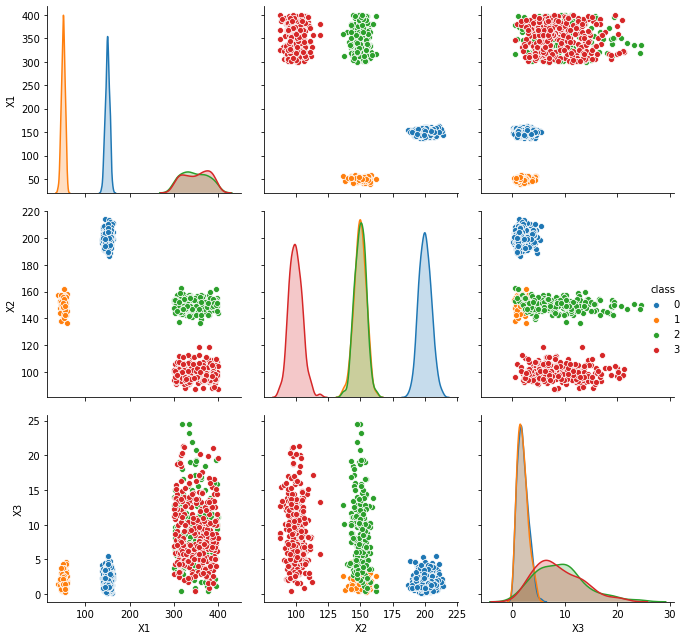

In [11]:
sns.pairplot(dbscan_data, height=3, hue='class')
plt.tight_layout()

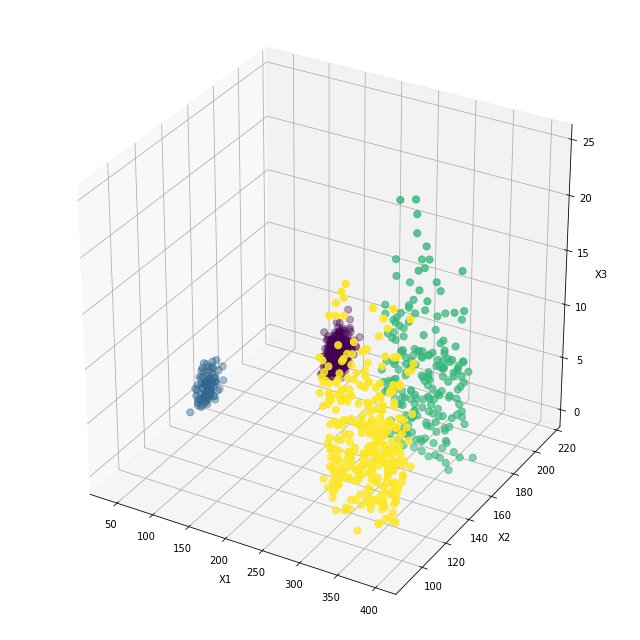

In [12]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(dbscan_data.X1, dbscan_data.X2, dbscan_data.X3, s=50, c = dbscan_data['class'])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.tight_layout()
plt.show()

## Porównania

Z powyższych wykresów widzimy, że DBSCAN dobrze sklasteryzował dane. k-means wymieszał ze sobą 2 skupienia. Warto więc będzie sprawdzić jak zachowa się po standaryzacji danych. Wykorzystamy wskaźnik silhouette oraz indeks Calińskiego-Harabasza - miary bazujące na odległościach pomiędzy punktami w klastrze.

Zweryfikujmy njapierw liczbę klastrów metodą łokcia dla k-means.

In [13]:
A=[]
for i in range(1,15):
    kmeans = cluster.KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(data)
    A.append((-1)*kmeans.score(data))

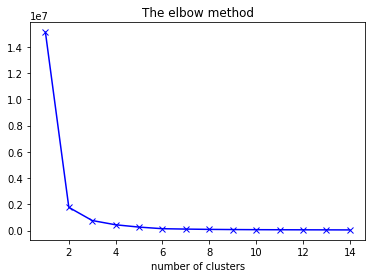

In [14]:
plt.plot(range(1,15), A, 'bx-')
plt.xlabel("number of clusters")
plt.title("The elbow method")
plt.show()

Zatem liczba klastrów, zgodnie z intuicją powinna wynosić nie więcej niż 4.

In [15]:
from sklearn.metrics import silhouette_score

In [16]:
silhouette_scores_kmeans = []
for i in range(2,5):
    y_pred = KMeans(data,i)
    silhouette_scores_kmeans.append(silhouette_score(data,y_pred))

In [17]:
silhouette_scores_kmeans

[0.8085010364583614, 0.8462944352356326, 0.6614753522212494]

In [18]:
silhouette_score(data, DBSCAN(data))

0.6837538942794454

Najbardziej interesuje nas wskaźnik silhouette dla 4 klastrów, by porównać go z wynikiem DBSCANa. Jak widać ten ostatni poradził sobie odrobinę lepiej.

In [19]:
from sklearn.metrics import calinski_harabasz_score

In [20]:
calinski_harabasz_score(data, KMeans(data,4))

11023.10869743483

In [21]:
calinski_harabasz_score(data, DBSCAN(data))

10517.009359038915

Tutaj natomiast widzimy przewagę k-means.

### Standaryzacja

Porównajmy wyniki po standaryzacji danych. Tutaj dobrym wyborem parametru eps dla DBSCANa będzie 0.4.

In [22]:
from sklearn import preprocessing
std_data = preprocessing.scale(data)

In [23]:
std_data

array([[-0.7628066 ,  1.0245538 , -0.9097716 ],
       [-0.8195822 ,  1.12510961, -0.56685344],
       [-0.73368686,  1.02961526, -1.00478229],
       ...,
       [ 1.26566688, -1.37499767,  0.66382337],
       [ 0.78865218, -1.29494446,  0.16144325],
       [ 1.02978572, -1.31091325,  3.07961344]])

In [24]:
silhouette_score(std_data,KMeans(std_data,4))

0.5912551358538592

In [25]:
silhouette_score(std_data,DBSCAN(std_data, 0.4))

0.5588632852847216

In [26]:
calinski_harabasz_score(std_data, KMeans(std_data,4))

2205.005027340979

In [27]:
calinski_harabasz_score(std_data, DBSCAN(std_data,0.4))

1265.2821802915453

Teraz w obu metrykach góruje kmeans. Zobaczmy wynik na wykresie.

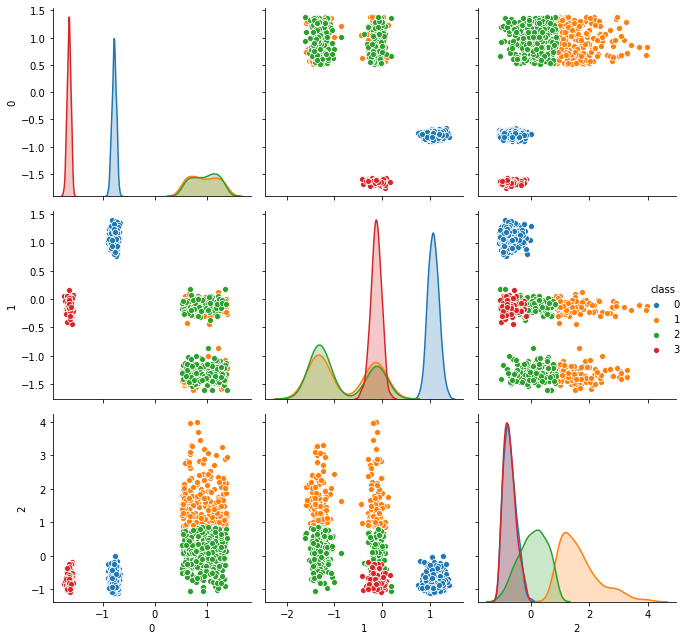

In [28]:
std_kmeans_data = pd.DataFrame(copy.deepcopy(std_data))
std_kmeans_data['class'] = KMeans(std_kmeans_data,4)
sns.pairplot(std_kmeans_data, height=3, hue='class')
plt.tight_layout()

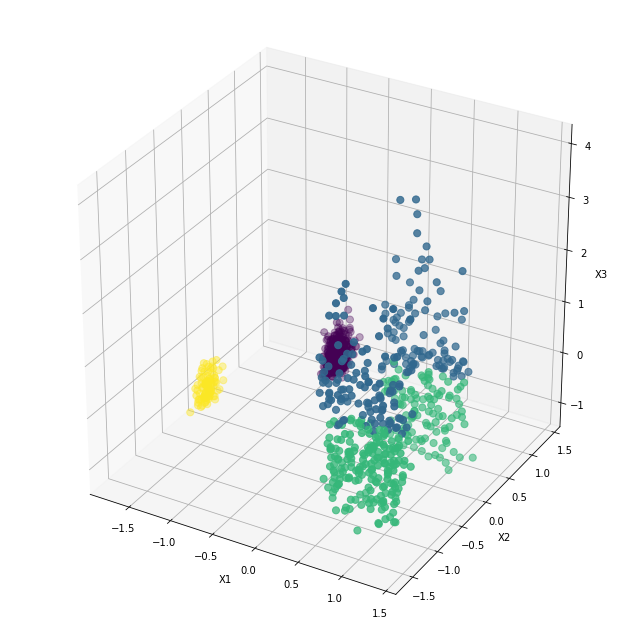

In [29]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(std_kmeans_data.iloc[:,0], std_kmeans_data.iloc[:,1], std_kmeans_data.iloc[:,2],
           s=50, c = std_kmeans_data['class'])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.tight_layout()
plt.show()

Tutaj dwa klastry nadal są wymieszane tym razem podzielone poziomo, nie tak jak przed standaryzacją - pionowo, jednakże wyniki miar są lepsze o DBSCANa. Podsumowując, jeśli bardziej nam zależy nam na mniejszych odległościach w klastrze i przez to lepszych wynikach miar, lepiej skorzystać z k-meansa. Jeśli natomiast chcemy trzymać się ludzkiej intuicji, DBSCAN na tym zbiorze radzi sobie bardzo dobrze, również bez standaryzacji.